In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41283/status,
Dashboard: http://127.0.0.1:41283/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35403,Workers: 2
Dashboard: http://127.0.0.1:41283/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:43977,Total threads: 4
Dashboard: http://127.0.0.1:34957/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:33871,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
product = 'landsat_8'
allmeasurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Running on data from St Maarten
dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat/'
ds = prep_dataset(dir, allmeasurements, product, clip_coords)

## Run data for Tile7572 
# dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# ds = prep_dataset(dir, allmeasurements, product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 7, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2022-11-20 ... 2018-03-14
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

## Cloud and Water Masking

In [6]:
water_mask = ls_clean_mask(ds, keep_water=True)

## Create Water Composite

In [7]:
mosaic_type = 'mean'

# Select and run the mosaic type
if mosaic_type in ['mean']:
    water_mosaic = water_mask.mean(dim=['time'])
elif mosaic_type in ['median']:
    water_mosaic = water_mask.median(dim=['time'])
else:
    print('invalid mosaic')


### Visualize Water Composite

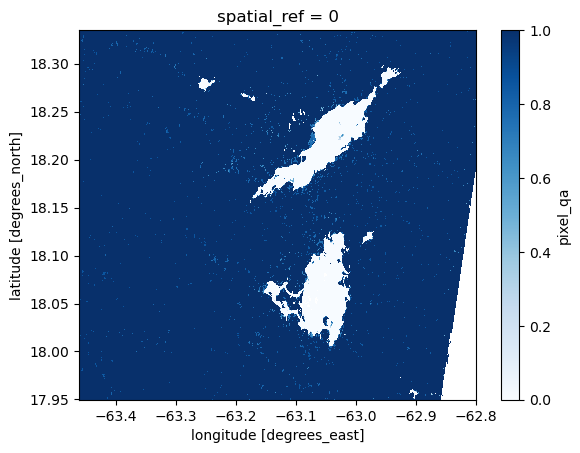

2024-01-11 11:20:01,249 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:43977', name: 0, status: running, memory: 0, processing: 0>
2024-01-11 11:20:01,485 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43977'.
2024-01-11 11:20:08,322 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:43977'. Shutting down.
2024-01-11 11:20:08,461 - distributed.core - INFO - Connection to tcp://127.0.0.1:35403 has been closed.


In [8]:
water_mosaic.plot.imshow(cmap='Blues', vmin=0, vmax=1)

## Export Desired Data

In [13]:
# Export the water mosaic as a COG
water_mosaic.rio.to_raster(f'StMaarten_WaterPermanency.tif', dtype='float32', driver='COG')